# Lab: Image classification with MLPs

------------------------------------------------------
*Leire Paz (Lab instructor): lpaz@pa.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
-----------------------------------------------------

In this lab, you will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to **shuffle the dataset every time we start going through the data loader again**. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

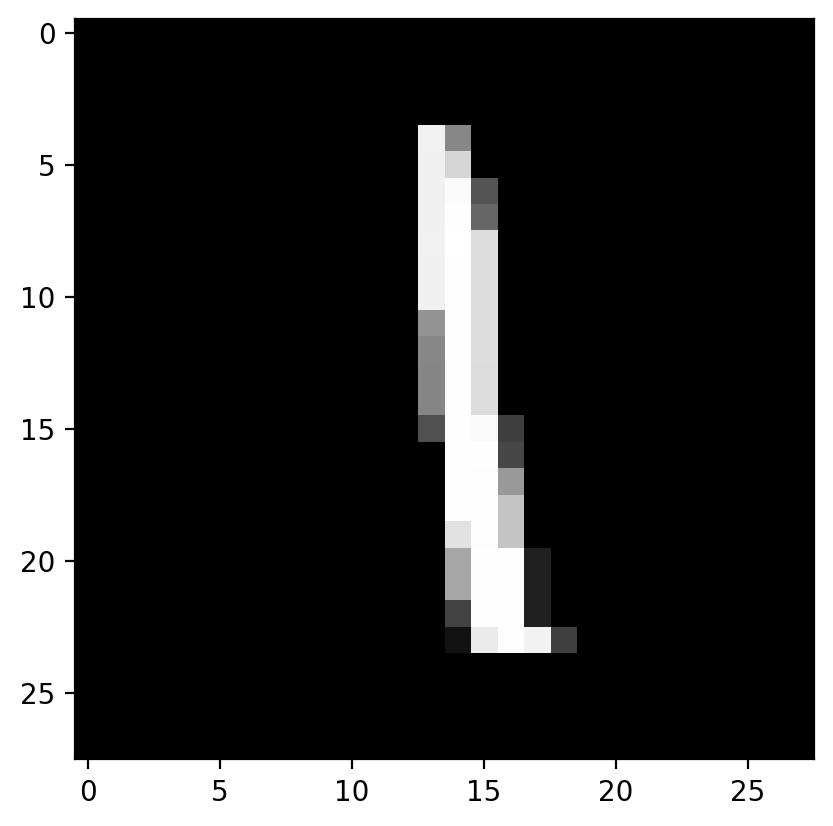

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Train a multi-class Logistic Regressor

Our first goal is to train a multi-class logistic regressor to evaluate how good it can do in both the training and the test sets. 

The following code is **almost identical** to the one you used for Lab 1 except for two small details:

- We are training a LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid). 

- We are using the MNIST database loaded above.

We first define the Multi-class Logistic Regressor class

> **Exercise**: Complete the following code

In [6]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output = nn.Linear(dimx,nlabels)
    
         
        self.logsoftmax = nn.LogSoftmax(dim=1)   # NEW w.r.t Lab 1. dim is the dimension along which 
                                                 #Softmax will be computed (so every slice along dim will sum to 1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.logsoftmax(x)
        return x

Note that we use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, we can use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor. 

> **Exercise**: Complete the following code

In [7]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()               
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Ok that was easy, wasn't it? Lets now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [8]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)


Training loss after 0 epochs: 0.470865
Training loss after 1 epochs: 0.328317
Training loss after 2 epochs: 0.308165
Training loss after 3 epochs: 0.300243
Training loss after 4 epochs: 0.294845


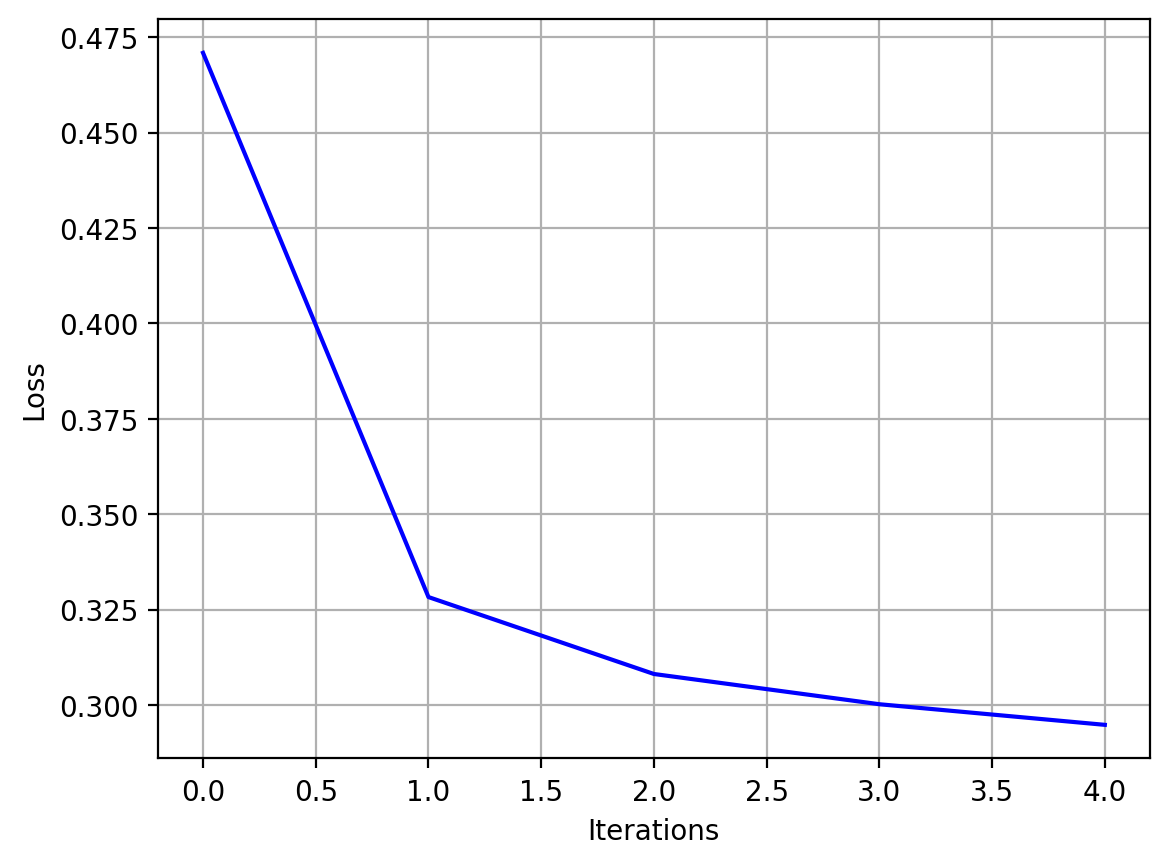

In [9]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [10]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:
        
        logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
        top_p, top_class = logprobs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    

print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.914510


With the probabilities, we can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line 
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting whether `top_class` is equal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean using `torch.mean()`.

> **Excercise** Modify the code of the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set (Use a single method with the proper inputs!). Compute the train/test accuracy using such a method.

In [11]:
#YOUR CODE HERE     
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()               
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
    def evaluate(self, trainloader):
        accuracy = 0
        with torch.no_grad():

            for images,labels in testloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Test Accuracy %f" %(accuracy/len(testloader)))


In [12]:
#YOUR CODE HERE    
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)
my_LR.evaluate(trainloader)
my_LR.evaluate(testloader)

Training loss after 0 epochs: 0.468778
Training loss after 1 epochs: 0.327400
Training loss after 2 epochs: 0.309133
Training loss after 3 epochs: 0.300241
Training loss after 4 epochs: 0.296503
Test Accuracy 0.916501
Test Accuracy 0.916501


Observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

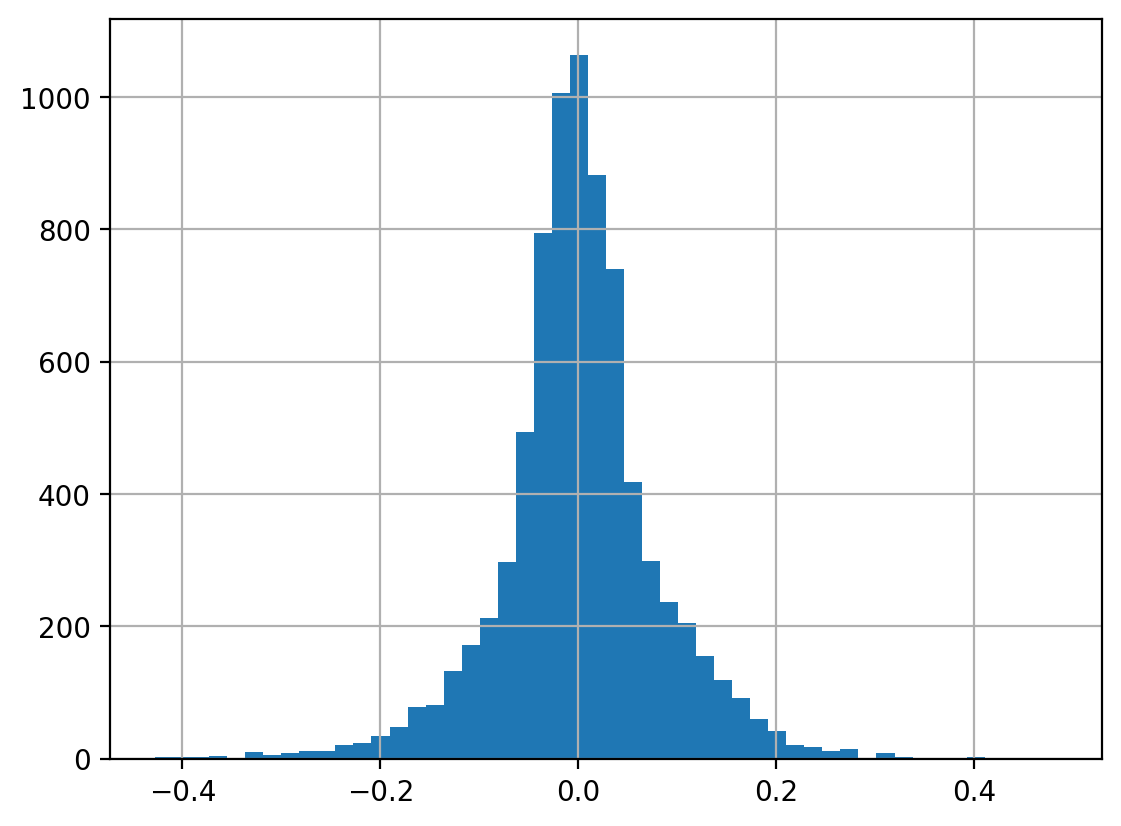

In [13]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50) # Modify my_LR by the name of the object you defined above
plt.grid()

> **Exercise**: Plot the histogram of the gradients of the loss function w.r.t. every parameter in the model:

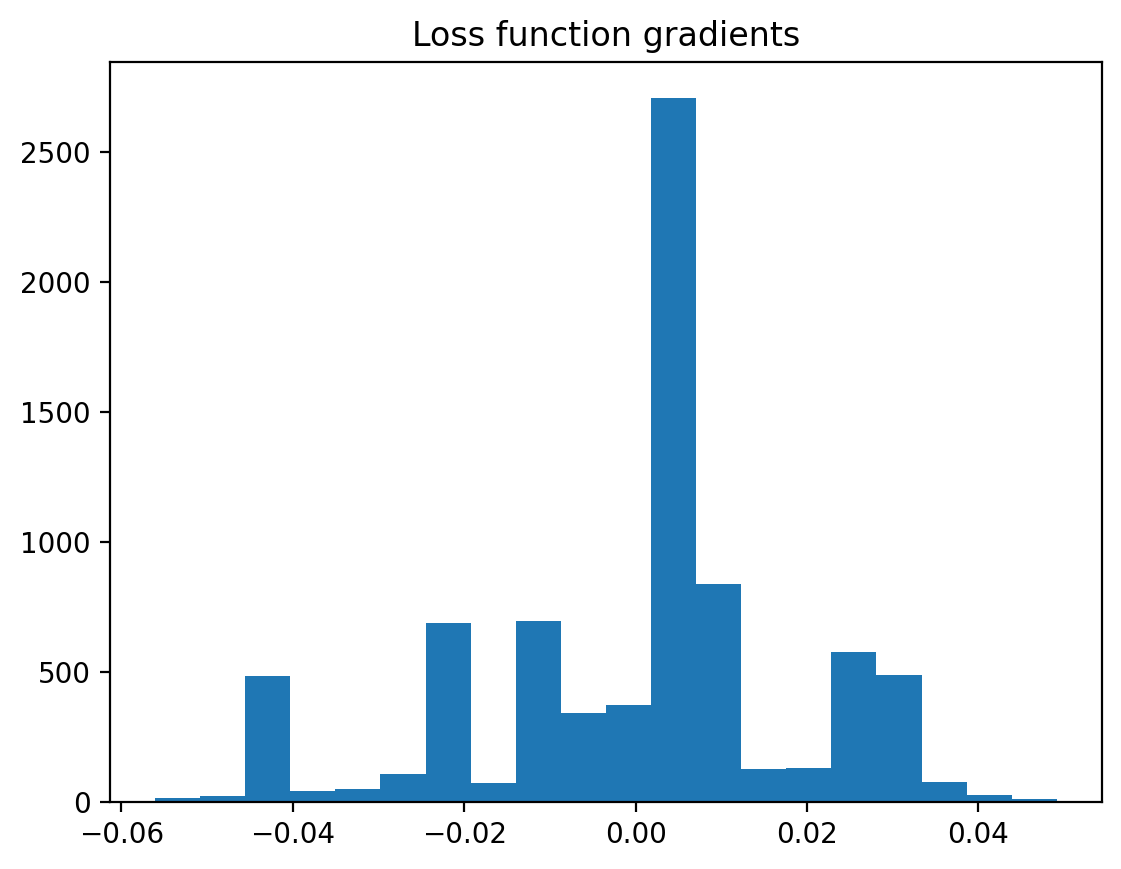

In [14]:
#YOUR CODE HERE
gradients = []
for param in my_LR.parameters():
    if param.grad is not None:
        gradients.extend(param.grad.detach().flatten())

plt.hist(gradients, bins=20)
plt.title("Loss function gradients")
plt.show()


As we can see most of the gradients are almost zero

## Part III. Train a MLP to do the same job

Modify the code you have just implemented for a MLP is straightforward. Assume we want to train a MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer, that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [15]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.

> **Exercise**: Complete the code for the following class

In [16]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

> **Excercise** Create a class `MLP_extended` that incorporates two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the code you have done above for the multi-class LR. This is why I like class and structure my code this way!!

In [17]:
#YOUR CODE HERE
class MLP_Extended(MLP):
    
    def __init__(self,dimx,hidden1, hidden2, nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx, hidden1, hidden2, nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()               
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
    def evaluate(self, trainloader):
        accuracy = 0
        with torch.no_grad():

            for images,labels in testloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Test Accuracy %f" %(accuracy/len(testloader)))


Train the model for 10 epochs and compute the train/test performance. Then plot the loss during trianing. How does it compare with the Logistic Regressor?

In [18]:
#YOUR CODE HERE
my_MLP = MLP_Extended(dimx=784,nlabels=10, hidden1=128, hidden2=64,epochs=10,lr=1e-3)

my_MLP.train(trainloader)
my_MLP.evaluate(trainloader)
my_MLP.evaluate(testloader)

Training loss after 0 epochs: 0.397691
Training loss after 1 epochs: 0.193610
Training loss after 2 epochs: 0.141600
Training loss after 3 epochs: 0.116389
Training loss after 4 epochs: 0.098950
Training loss after 5 epochs: 0.085123
Training loss after 6 epochs: 0.075222
Training loss after 7 epochs: 0.068516
Training loss after 8 epochs: 0.061524
Training loss after 9 epochs: 0.055952
Test Accuracy 0.971238
Test Accuracy 0.971537


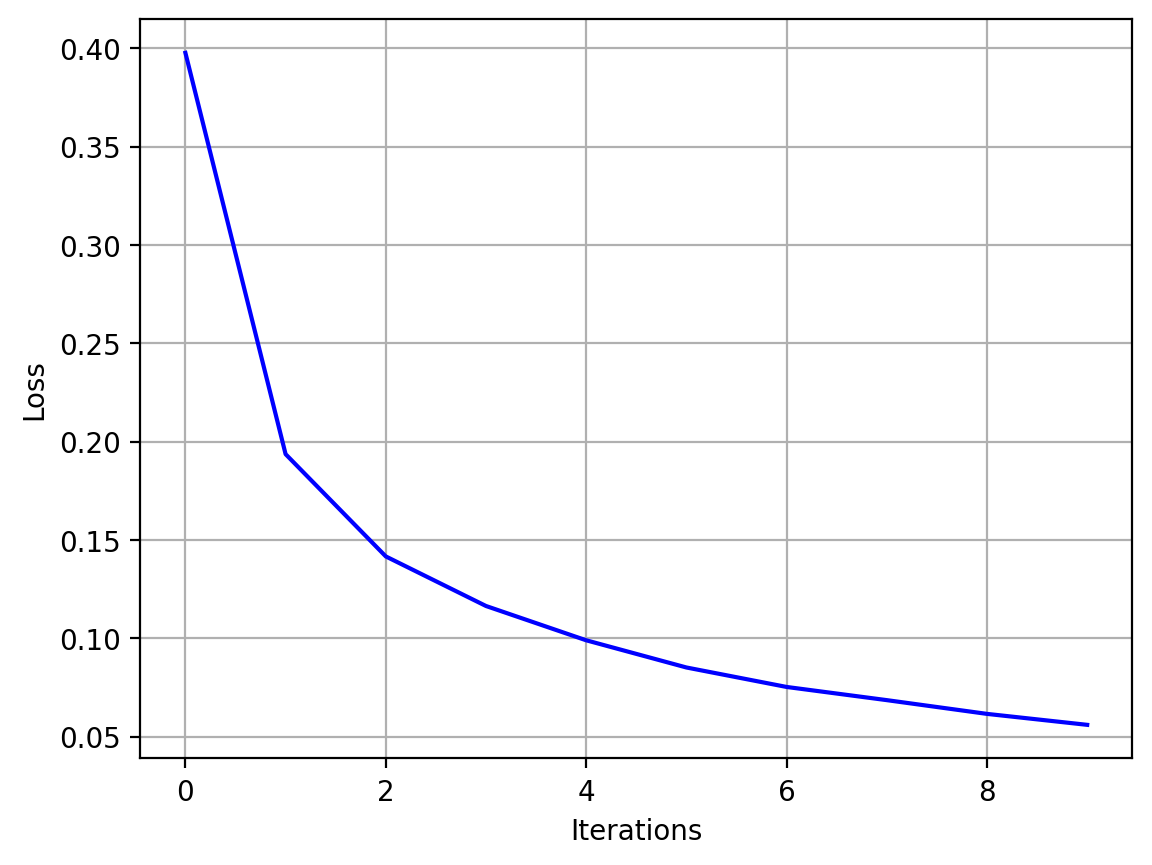

In [19]:
gradients = []
for param in my_MLP.parameters():
    if param.grad is not None:
        gradients.extend(param.grad.detach().flatten())

plt.plot(my_MLP.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

Wow! Performace is almost perfect with a naive Neural Network!!

> **Exercise:** Lets visualize the activations at the ouput of the first layer for a minibatch of test images. This will help to identify possible unused hidden units (always activated/deactivated) and correlated hidden units, e.g. redundant units. Complete the following code.

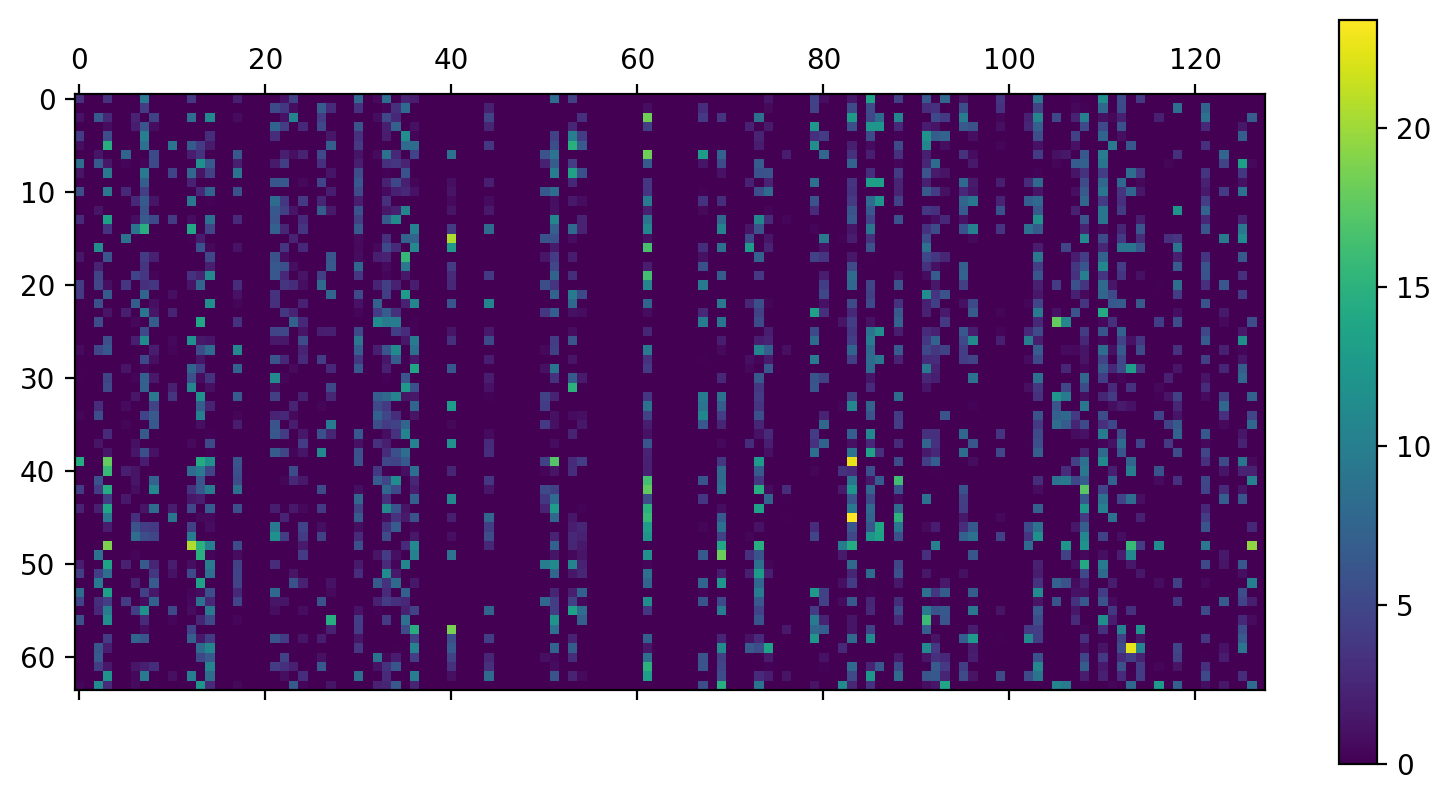

In [20]:
# First, we load a test minibatch

x_test,y_test = next(iter(testloader)) 

# Then, we evaluate the output of the first layer of the network for that mini-batch
activations = my_MLP.relu(my_MLP.output1(x_test.view(x_test.shape[0], -1))).detach().numpy()

# We plot the matrix using matplotlib

plt.matshow(activations)

plt.colorbar()


Based on the plot, do you think there are unsued hidden units in the hidden layer? They are characterized by units that are always active (very high values) or unactive (almost zero values). Plot the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units. 

There are 60 hidden units that are unactive


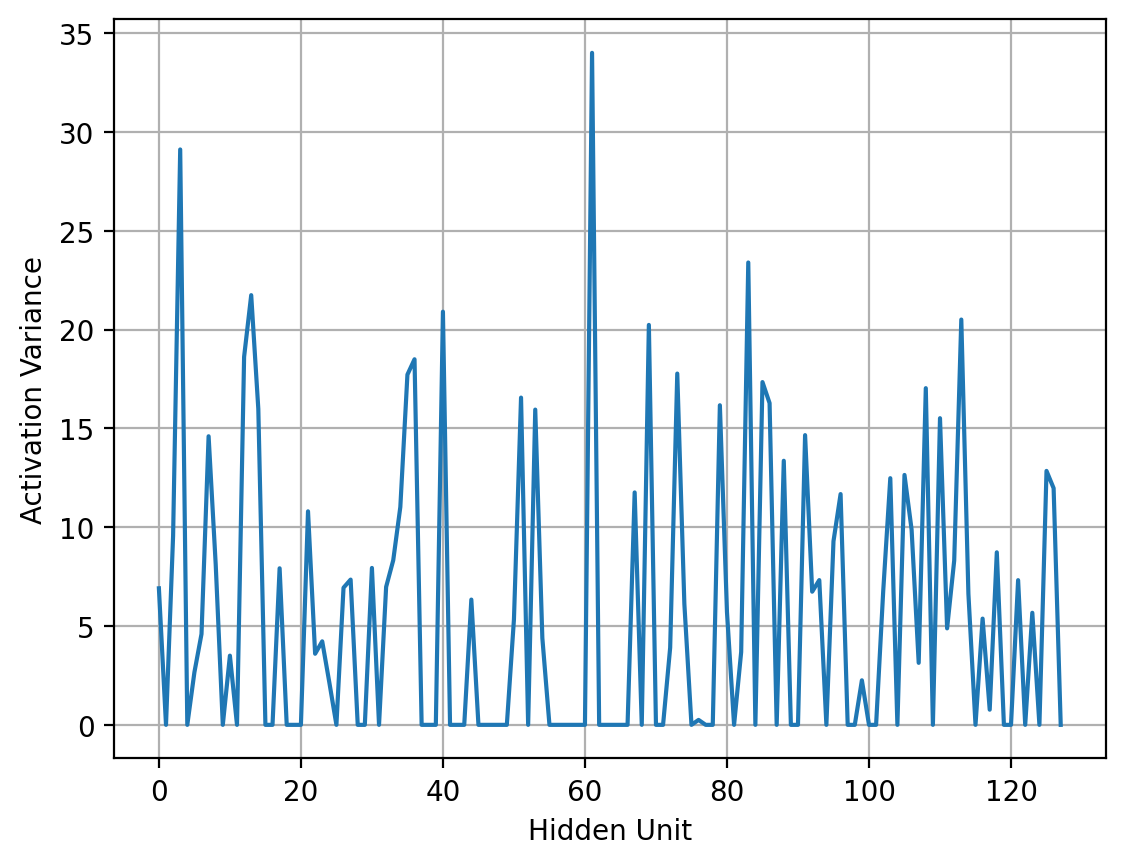

In [21]:
plt.plot(np.var(activations,0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

print("There are {0:d} hidden units that are unactive".format(np.sum(np.var(activations,0)<=0.1)))

> **Exercise**: Retrain the model reducing accordingly the dimension of the first hidden layer. For that model, repeat the analysis to the activations of both the first and the second layer. 
>
>You will notice that in general, unsued activations are prominent in the first layer compared to the second one. This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more in the loss function), while many others vary very little w.r.t. initialization.

Training loss after 0 epochs: 0.420110
Training loss after 1 epochs: 0.211397
Training loss after 2 epochs: 0.157267
Training loss after 3 epochs: 0.127964
Training loss after 4 epochs: 0.111572
Training loss after 5 epochs: 0.101156
Training loss after 6 epochs: 0.088911
Training loss after 7 epochs: 0.083032
Training loss after 8 epochs: 0.073605
Training loss after 9 epochs: 0.069330
Test Accuracy 0.972731
Test Accuracy 0.972731


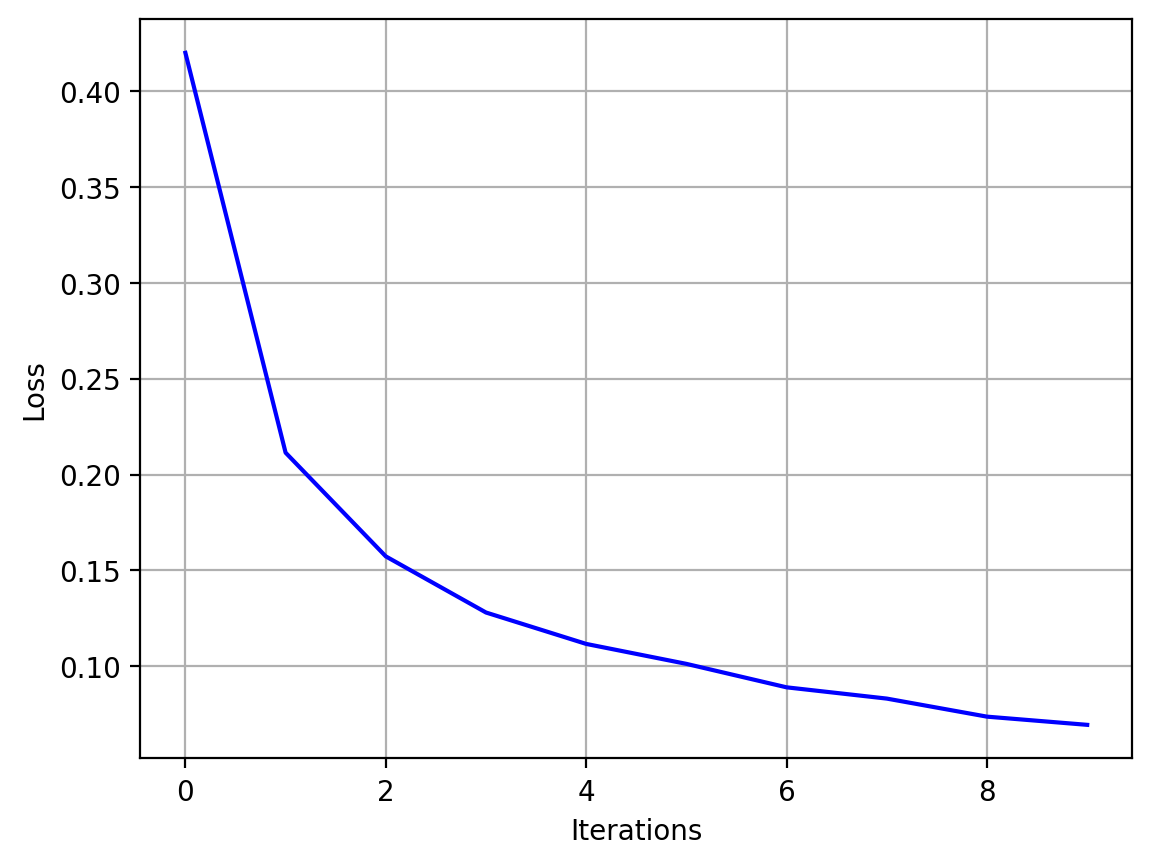

In [22]:
#YOUR CODE HERE
new_hidden1 = 128 - np.sum(np.var(activations,0)<=0.1)
my_MLP = MLP_Extended(dimx=784,nlabels=10, hidden1=new_hidden1, hidden2=64,epochs=10,lr=1e-3)

my_MLP.train(trainloader)
my_MLP.evaluate(trainloader)
my_MLP.evaluate(testloader)

plt.plot(my_MLP.loss_during_training,'-b', label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In the first layer, there are 25 hidden units that are unactive
In the second layer, there are 0 hidden units that are unactive


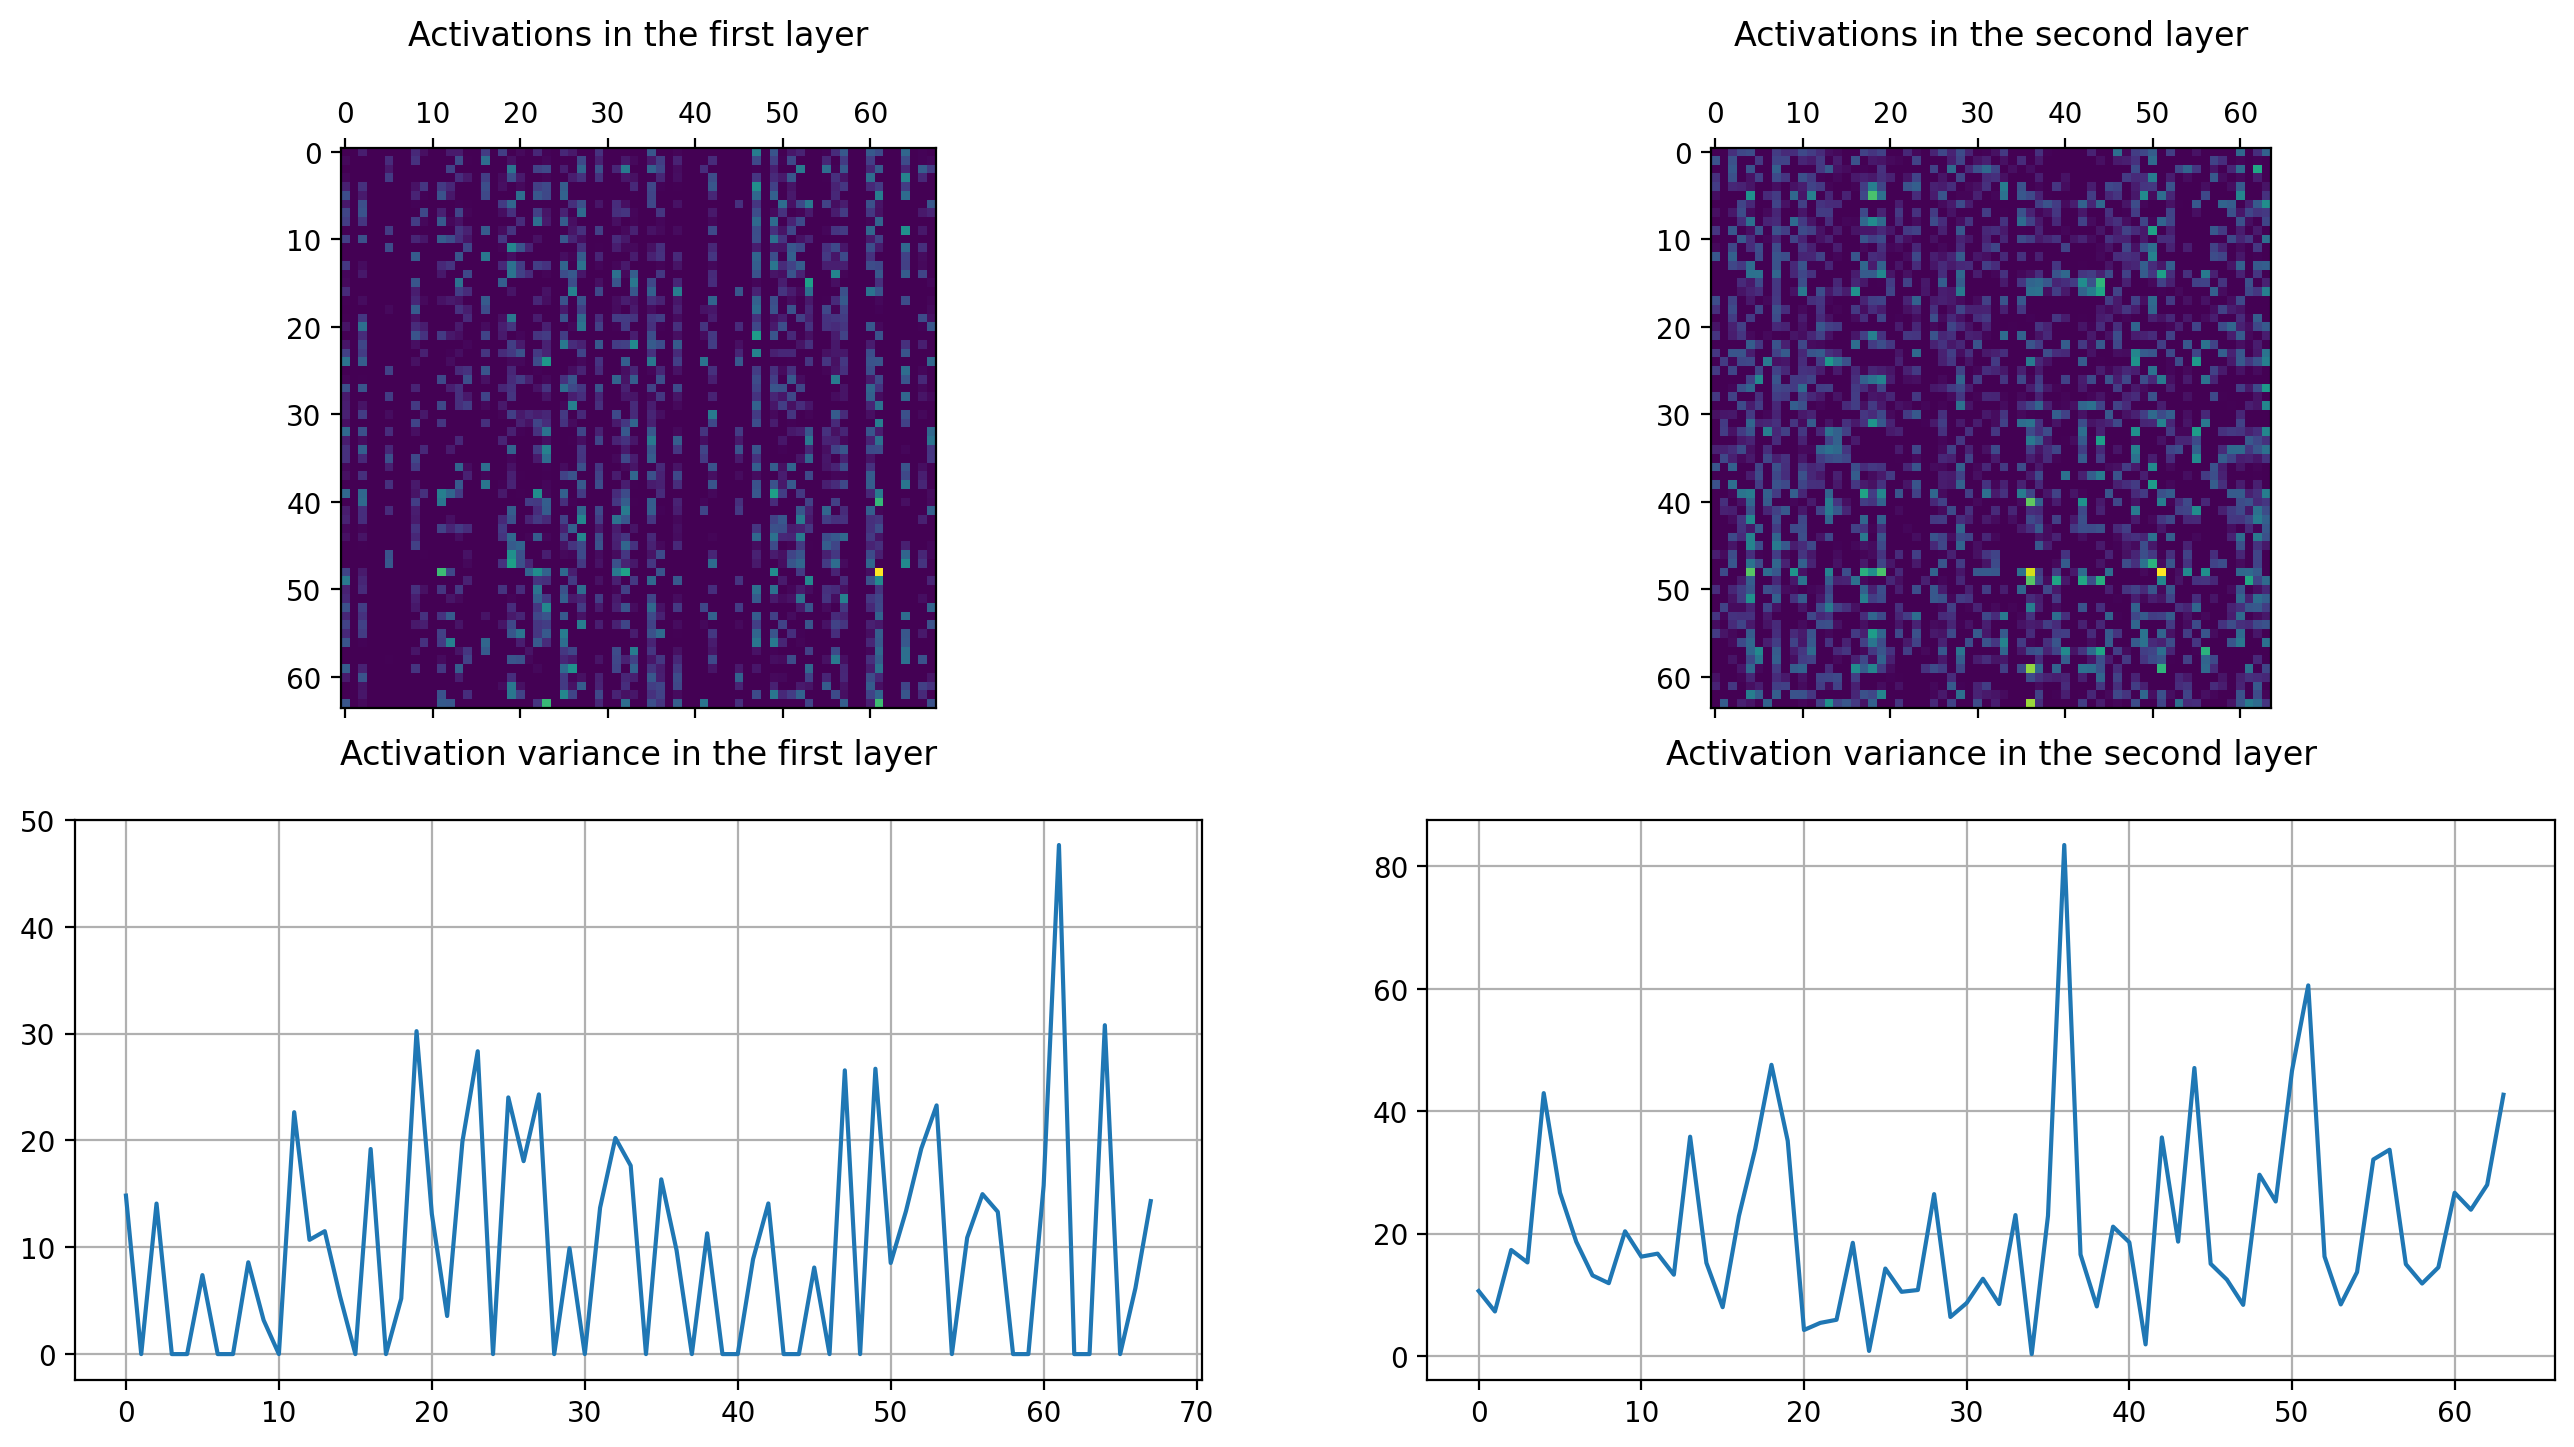

In [23]:
activations_1 = my_MLP.relu(my_MLP.output1(x_test.view(x_test.shape[0], -1))).detach().numpy()

# Then, we evaluate the output of the first layer of the network for that mini-batch
activations_2 = my_MLP.relu(my_MLP.output2(my_MLP.output1(x_test.view(x_test.shape[0], -1)))).detach().numpy()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1)
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2)
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1,0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2,0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

print("In the first layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_1,0)<=0.1)))

print("In the second layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_2,0)<=0.1)))

> **Exercise**: Plot the histogram of the gradient of the loss function w.r.t. the parameters in the model for the first and the last layers and compare them.

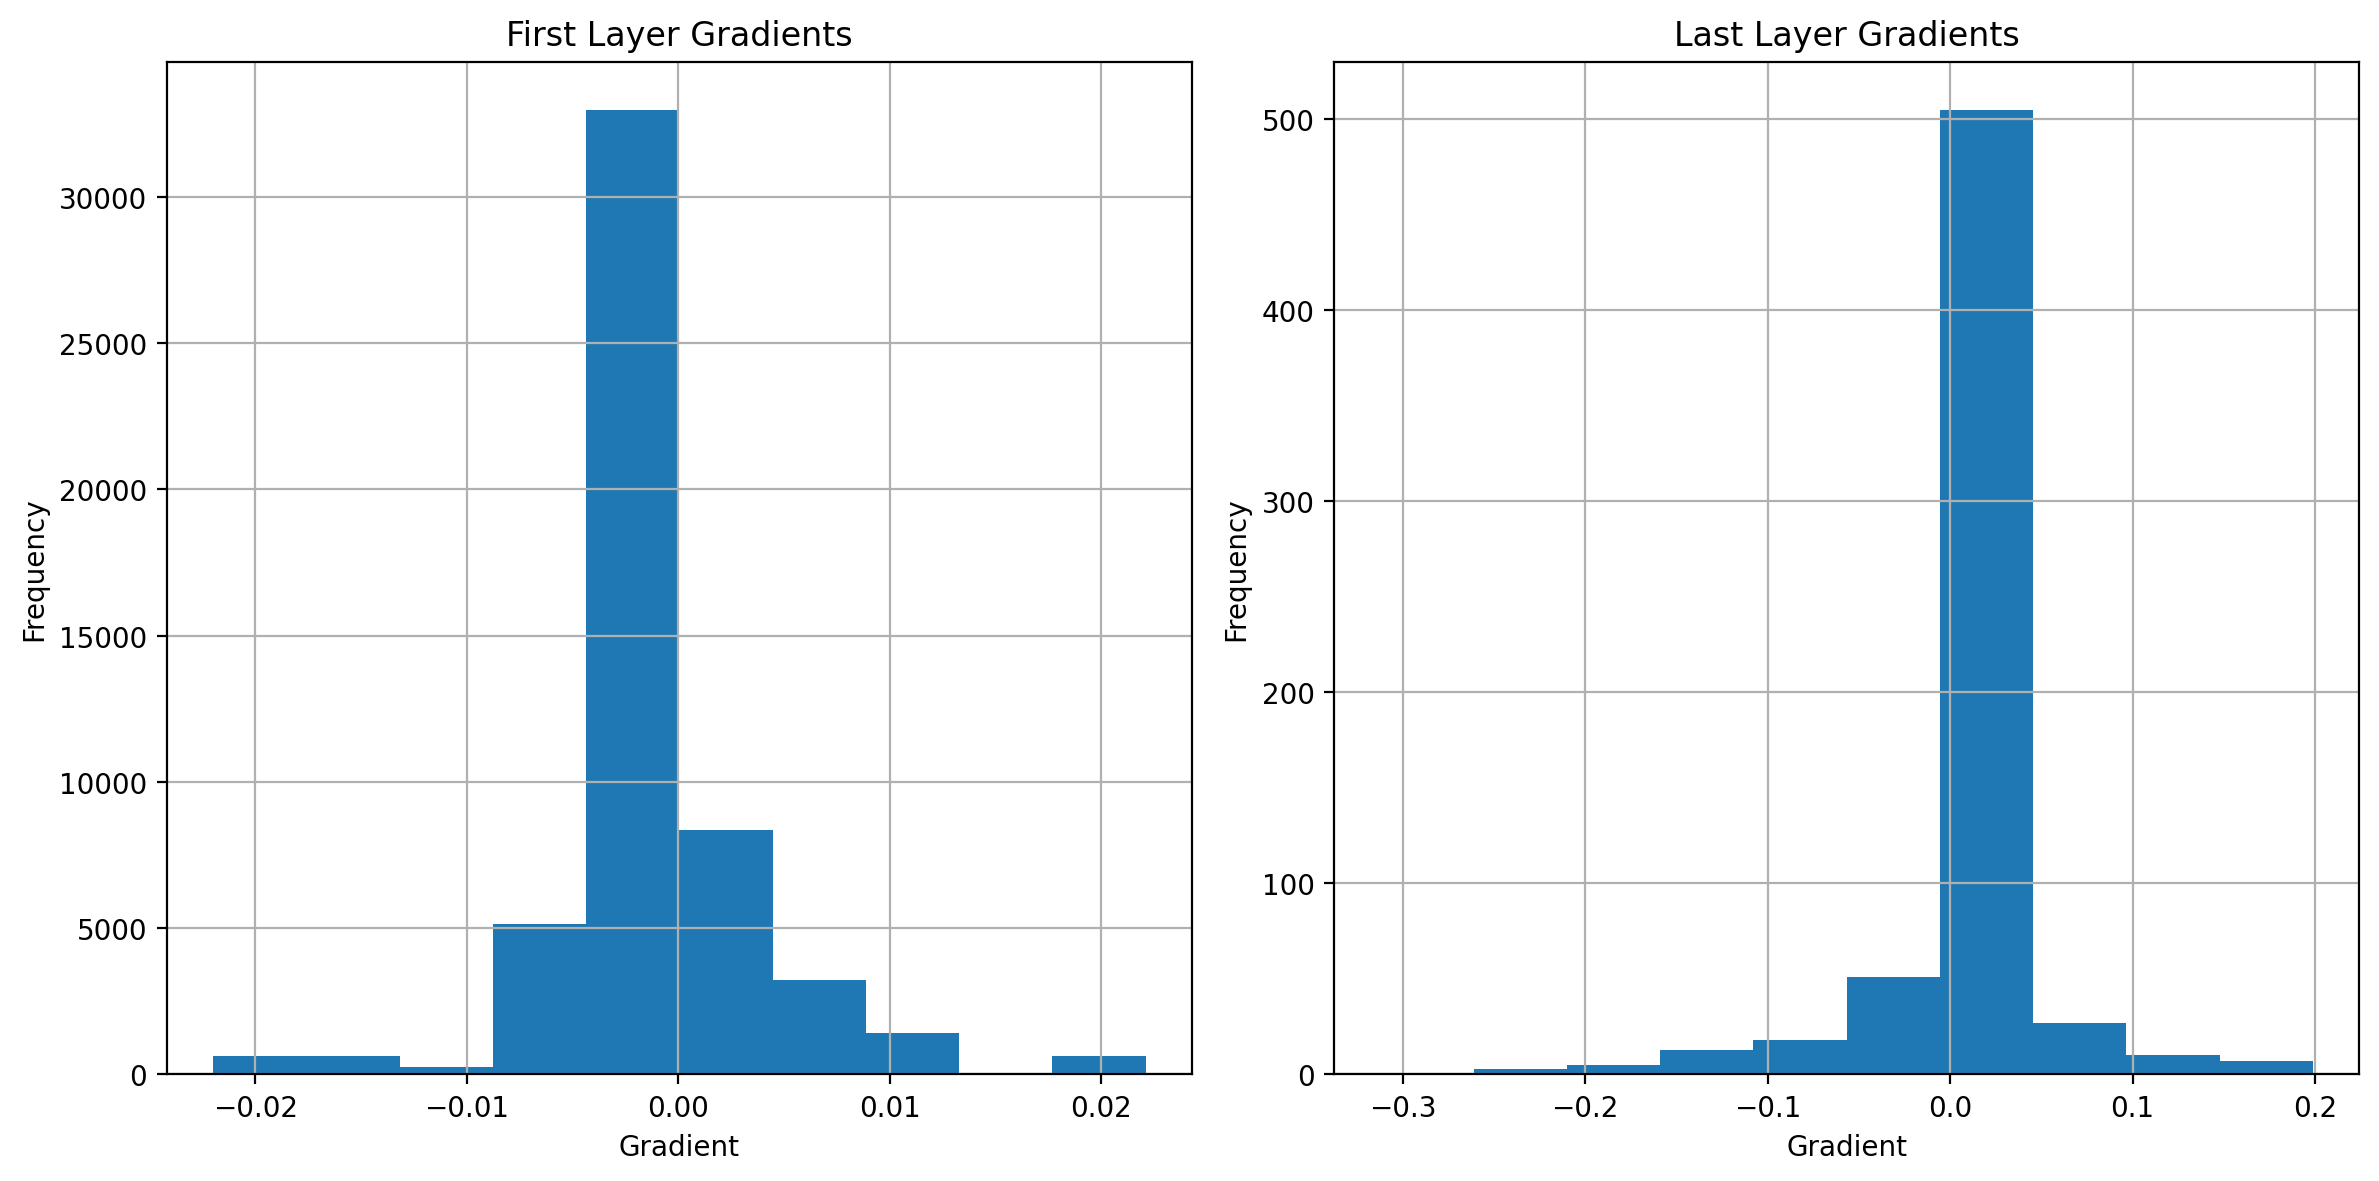

In [24]:
# YOUR CODE HERE
first_layer_gradients = []
last_layer_gradients = []

for param in my_MLP.parameters():
    if param.grad is not None:
        if param is my_MLP.output1.weight:
            first_layer_gradients.extend(param.grad.detach().numpy().flatten())
        elif param is my_MLP.output3.weight:
            last_layer_gradients.extend(param.grad.detach().numpy().flatten())

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(first_layer_gradients)
plt.title("First Layer Gradients")
plt.grid()
plt.xlabel("Gradient")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(last_layer_gradients)
plt.title("Last Layer Gradients")
plt.grid()
plt.xlabel("Gradient")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Part IV. Saving and restoring the model

Finally, we will show you how to save and load models (i.e. values of the parameters) with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [25]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Our model: 

 MLP_Extended(
  (output1): Linear(in_features=784, out_features=68, bias=True)
  (output2): Linear(in_features=68, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
) 

The state dict keys: 

 odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


The simplest thing to do is saving the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [26]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [27]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


C:\Users\alvar\AppData\Local\Temp\ipykernel_16188\3138749330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('checkpoint.pth')


And to load the state dict in to the network, you do `my_MLP.load_state_dict(state_dict)`.

In [28]:
my_MLP.load_state_dict(state_dict)

<All keys matched successfully>

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [29]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

NameError: name 'MLP_extended' is not defined

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> **Exercise:** Check that you get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [30]:
my_MLP2.load_state_dict(state_dict)

NameError: name 'my_MLP2' is not defined